In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import json

In [2]:
curr_dir=os.getcwd()
grandparent_dir = os.path.abspath(os.path.join(curr_dir, os.pardir,os.pardir))
print(grandparent_dir)
sys.path.append(os.path.join(grandparent_dir))
sys.path.append(os.path.join(grandparent_dir, 'liset_tk'))
print(sys.path)

from liset_aux import ripples_std, middle


c:\Users\NCN\Documents\PedroFelix\LAVA_SNN_ripples
['c:\\nrn\\lib\\python', 'c:\\Users\\NCN\\Miniconda3\\envs\\lava_snn_ripples\\python39.zip', 'c:\\Users\\NCN\\Miniconda3\\envs\\lava_snn_ripples\\DLLs', 'c:\\Users\\NCN\\Miniconda3\\envs\\lava_snn_ripples\\lib', 'c:\\Users\\NCN\\Miniconda3\\envs\\lava_snn_ripples', '', 'c:\\Users\\NCN\\Miniconda3\\envs\\lava_snn_ripples\\lib\\site-packages', 'c:\\Users\\NCN\\Miniconda3\\envs\\lava_snn_ripples\\lib\\site-packages\\win32', 'c:\\Users\\NCN\\Miniconda3\\envs\\lava_snn_ripples\\lib\\site-packages\\win32\\lib', 'c:\\Users\\NCN\\Miniconda3\\envs\\lava_snn_ripples\\lib\\site-packages\\Pythonwin', 'c:\\Users\\NCN\\Documents\\PedroFelix\\LAVA_SNN_ripples', 'c:\\Users\\NCN\\Documents\\PedroFelix\\LAVA_SNN_ripples\\liset_tk']


In [ ]:
# parent = r"C:\__NeuroSpark_Liset_Dataset__\neurospark_mat\CNN_TRAINING_SESSIONS" # Modify this to your data path folder
parent = r"C:\__NeuroSpark_Liset_Dataset__\neurospark_mat\Download_from_paper" # Modify this to your data path folder
# parent=r"E:\neurospark_mat\CNN_TRAINING_SESSIONS"
# parent=r"E:\neurospark_mat\Download_from_paper"

bandpass=[100,250]
downsampled_fs = False # Downsampled frequency
factor=downsampled_fs//1000 if downsampled_fs else 30
time_max=120
window_size=0.05
sample_ratio=0.25
scaling_factor=1
refractory=0
percentile=False

In [4]:
dt=1  # Time step in milliseconds (1 ms)


RIPPLE_DETECTION_OFFSET = [18, 45, 31, 20] # it's calculated as 4.5 periods of the ripple wavelet - for 100 Hz and 250 Hz as the limit frequencies
# The Windows for HFO detection are based on the MAX DETECTION OFFSET

#TODO - Why are these values? Can I tune them in a better way?
RIPPLE_CONFIDENCE_WINDOW = int(round(RIPPLE_DETECTION_OFFSET[1] * 1.8)) 

# in timesteps (ms) - Max time from the Insertion Timing to the GT annotation
MAX_DETECTION_OFFSET = RIPPLE_DETECTION_OFFSET[1]   # in timesteps (ms)

MEAN_DETECTION_OFFSET = RIPPLE_DETECTION_OFFSET[2]   # in timesteps (ms)

WINDOW_SIZE = int(RIPPLE_DETECTION_OFFSET[1]*4)   # in timesteps (ms) - The size of the window to slice the input data

# unit: timesteps (ms) - The number of steps that 2 consecutive windows must overlap to not lose any relevant CBs

# std, mean = ripples_std(parent) # 61 ms # in seconds
# INTERSECT_WINDOW_LEN=int((std+mean)*1000) # in timesteps (ms) - The size of the intersection window to slice the input data
INTERSECT_WINDOW_LEN=60 # in timesteps (ms) - The size of the intersection window to slice the input data

# unit: timesteps (ms) - The number of steps that the window must shift to get the next window
WINDOW_SHIFT = int(WINDOW_SIZE - INTERSECT_WINDOW_LEN)

# unit: timesteps (ms) - The time window after the GT annotation where the network should predict the burst (GT_time, GT_time + PRED_CAUSALITY_WINDOW)
# This is needed to give the network some extra time steps to increase the membrane potential and spike
PRED_CAUSALITY_WINDOW = int(5)     # Giving PRED_CAUSALITY_WINDOW ms for the network to update its inner state and spike   

# unit: timesteps (ms) - The time window around the GT annotation where the network should predict the burst (GT_time - PRED_GT_TOLERANCE, GT_time + PRED_GT_TOLERANCE)
PRED_GT_TOLERANCE = int(RIPPLE_DETECTION_OFFSET[3])  # in timesteps (ms)
print(f"WINDOW_SIZE: {WINDOW_SIZE}")
print(f"INTERSECT_WINDOW_LEN: {INTERSECT_WINDOW_LEN} (MEAN+STD)")
print(f"WINDOW_SHIFT: {WINDOW_SHIFT}")
print(f"MEAN DETECTION OFFSET: {MEAN_DETECTION_OFFSET}")
print(f"PRED_GT_TOLERANCE: {PRED_GT_TOLERANCE}")
print(f"PRED_CAUSALITY_WINDOW: {PRED_CAUSALITY_WINDOW}")

WINDOW_SIZE: 180
INTERSECT_WINDOW_LEN: 60 (MEAN+STD)
WINDOW_SHIFT: 120
MEAN DETECTION OFFSET: 31
PRED_GT_TOLERANCE: 20
PRED_CAUSALITY_WINDOW: 5


In [5]:
config = {
    "bandpass": bandpass,
    "downsampled_fs": downsampled_fs,
    "time_max": time_max,
    "window_size": window_size,
    "sample_ratio": sample_ratio,
    "scaling_factor": scaling_factor,
    "refractory": refractory,
    "dt":dt,
    "percentile":percentile,
    "WINDOW_SHIFT": WINDOW_SHIFT,
    "WINDOW_SIZE": WINDOW_SIZE,
    "INTERSECT_WINDOW_LEN": INTERSECT_WINDOW_LEN,
    "RIPPLE_DETECTION_OFFSET": RIPPLE_DETECTION_OFFSET,
    "PRED_CAUSALITY_WINDOW": PRED_CAUSALITY_WINDOW,
}

In [6]:
from signal_aid import most_active_channel, bandpass_filter


## Extract Windows
Extract UP/DN spike Windows


In [7]:
load=False

from extract_Nripples.utils_encoding import *
# Only run this block if first time
if 'windowed_input_data' not in locals():
    if load:
        windowed_path=os.path.join(curr_dir,"windowed_data")
        windowed_input_data = np.load(os.path.join(windowed_path,"windowed_input_data.npy"))
        windowed_gt = np.load(os.path.join(windowed_path,"windowed_gt.npy"))
        filtered_windows=np.load(os.path.join(windowed_path,"filtered_windows.npy"))
    else:
        # from make_windows import *
        # windowed_input_data, windowed_gt, filtered_windows, config=make_windows(parent,config,time_max,downsampled_fs,bandpass,window_size,sample_ratio, scaling_factor, 
        #              refractory,WINDOW_SHIFT, WINDOW_SIZE,MEAN_DETECTION_OFFSET,MAX_DETECTION_OFFSET,factor)
        from make_windows2 import *
        windowed_input_data, windowed_gt, filtered_windows,ripple_ids, config=make_windows_mesquita(parent,config,time_max,downsampled_fs,bandpass,window_size,sample_ratio, scaling_factor, 
                     refractory,WINDOW_SHIFT, WINDOW_SIZE,MEAN_DETECTION_OFFSET,MAX_DETECTION_OFFSET,factor)
else:
    print("windowed_input_data already loaded")

data shape:  (71965696, 8)
ripples shape:  (1309, 2)
[WARNING] Window [3110400:3115800] has a GT event at [3112068 3113598] and NO Input activations. Skipping...
[WARNING] Window [13035600:13041000] has a GT event at [13034561 13035700] and NO Input activations. Skipping...
[WARNING] Window [64126800:64132200] has a GT event at [64125667 64126838] and NO Input activations. Skipping...
[WARNING] Current window [71960400, 71965800] is smaller than the expected size. Breaking the loop...
[WARNING] Window [13035600:13041000] has a GT event at [13034561 13035700] and NO Input activations. Skipping...
[WARNING] Window [50047200:50052600] has a GT event at [50044897 50047207] and NO Input activations. Skipping...
[WARNING] Window [64126800:64132200] has a GT event at [64125667 64126838] and NO Input activations. Skipping...
[WARNING] Window [69282000:69287400] has a GT event at [69280363 69282023] and NO Input activations. Skipping...
[WARNING] Current window [71960400, 71965800] is smaller t

In [8]:
up_spikes_per_window = np.sum(windowed_input_data[:, :, 0], axis=1)    # Sum along time axis
down_spikes_per_window = np.sum(windowed_input_data[:, :, 1], axis=1)  # Sum along time axis
print("Up Spikes Total:",np.sum(up_spikes_per_window))
print("Down Spikes Total:",np.sum(down_spikes_per_window))

Up Spikes Total: 1941704.0
Down Spikes Total: 1960378.0


In [9]:
# See GT Class Distribution
# Set print options to see more elements
np.set_printoptions(linewidth=100, threshold=50, edgeitems=20)
print(f"Ground Truth Class Distribution: {np.unique(windowed_gt, return_counts=True)}")
GT_HFO_MASK = windowed_gt >= 0
# print(windowed_gt[0:1000])
# Define the number of windows with an HFO
num_hfo_windows = np.sum(GT_HFO_MASK)
print(f"Number of windows with an HFO: {num_hfo_windows}")
print(f"Percentage of windows with an HFO: {num_hfo_windows / windowed_gt.shape[0] * 100:.2f}%")


Ground Truth Class Distribution: (array([ -1.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49., ..., 146., 147., 148., 149., 150., 151., 152., 153., 154.,
       155., 156., 157., 158., 159., 160., 161., 162., 163., 164., 165.], dtype=float32), array([275204,    144,    182,    154,    184,    238,    168,    175,    191,    213,    231,
          160,    244,    230,    159,    240,    248,    160,    200,    174, ...,    181,    112,
          160,    112,    159,    104,    151,    119,    120,    191,    128,    111,    152,
          136,    160,    120,    173,    153,    119,    160], dtype=int64))
Number of windows with an HFO: 23978
Percentage of windows with an HFO: 8.01%


In [10]:
# Find the indices to sort the input data by the nº of UP/DN spikes (descending order)
sorted_indices = np.argsort(
    -(np.sum(windowed_input_data[:, :, 0], axis=1) + np.sum(windowed_input_data[:, :, 1], axis=1)), 
)
sorted_spikes = windowed_input_data[sorted_indices]
sorted_gt= windowed_gt[sorted_indices]
sorted_filtered_windows=filtered_windows[sorted_indices]
sorted_ripples=ripple_ids[sorted_indices]
sorted_up_spikes_per_window = np.sum(sorted_spikes[:, :, 0], axis=1)    # Sum along time axis
sorted_down_spikes_per_window = np.sum(sorted_spikes[:, :, 1], axis=1)  # Sum along time axis
print(f"sorted_indices: {sorted_indices}")
print(f"Sorted_data: {sorted_spikes.shape} | Sorted_gt: {sorted_gt.shape}| Sorted_filtered_windows: {sorted_filtered_windows.shape}")
print(f"Sorted_gt preview: {sorted_gt[:10]}")
print(f"GT first window: {sorted_gt[0]} | GT last window: {sorted_gt[-1]}")

sorted_indices: [  9818  16191   7392  34524  27941  28292  16192  14591   9464 221936  39612  15008  12278  46548
 229396  26889  34525  16350   3824 214650 ... 292057 281857 117016 187188 269228 214225 281877
 292032 292031 157693 157678 157674 157669 214226 187249  41326 187260 157617 157608 276261]
Sorted_data: (299182, 180, 2) | Sorted_gt: (299182,)| Sorted_filtered_windows: (299182, 5400)
Sorted_gt preview: [ -1. 115.  42. 115.  67.  -1.  -1.  82.  67.  33.]
GT first window: -1.0 | GT last window: -1.0


In [78]:
sorted_gt_distribution=sorted_gt[:1000]
print(f"Sorted GT Distribution: {np.unique(sorted_gt_distribution, return_counts=True)}")


Sorted GT Distribution: (array([ -1.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,
        46.,  47.,  48.,  49.,  50., ..., 142., 143., 145., 146., 148., 149., 150., 151., 152.,
       153., 154., 155., 156., 157., 158., 159., 160., 162., 163., 164.], dtype=float32), array([53,  6, 11,  7,  2, 14,  4, 11,  4, 15,  8, 18, 13, 23,  3,  8,  8,  5,  9,  9, ...,  1,  1,
       11,  9,  7,  1,  6,  1,  8,  3,  6,  1,  2,  1,  6,  4,  6,  3,  1,  3], dtype=int64))


180


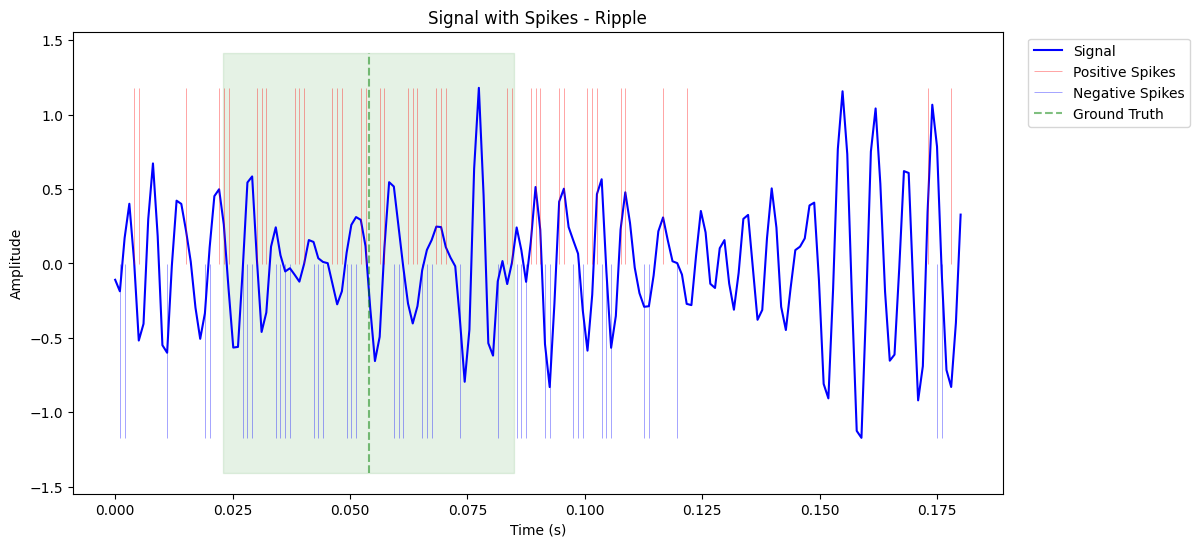

Total Spikes: 83.0
Up Spikes: 41.0
Down Spikes: 42.0


In [99]:
from snnTorch.utils.util import window_plot
window=100
plot_spikes=sorted_spikes[window,:,:]
# plot_filtered_window=sorted_filtered_windows[window,::factor]
plot_filtered_window=average_downsampling(sorted_filtered_windows[window,:], factor)
# plot_filtered_window=decimation_downsampling(sorted_filtered_windows[window,:], factor)
# TODO  - Check if the filtered window is correct (very weird results)

plot_gt=sorted_gt[window]
window_plot(plot_filtered_window,plot_spikes, plot_gt,downsampled_fs=1000,detection_window=RIPPLE_DETECTION_OFFSET)
up_spikes_window = np.sum(plot_spikes[:, 0])    # Sum along time axis
down_spikes_window = np.sum(plot_spikes[:, 1])  # Sum along time axis
print("Total Spikes:",up_spikes_window+down_spikes_window)
print("Up Spikes:",sorted_up_spikes_per_window[window])
print("Down Spikes:",sorted_down_spikes_per_window[window])

In [13]:
is_hfo = windowed_gt >= 0
hfo_windows = windowed_input_data[is_hfo]       # shape: (N_HFO, 180, 2)
non_hfo_windows = windowed_input_data[~is_hfo]  # shape: (N_nonHFO, 180, 2)
windowed_gt_hfo = windowed_gt[is_hfo]       # shape: (N_HFO, 180, 2)
windowed_gt_non_hfo = windowed_gt[~is_hfo]  # shape: (N_nonHFO, 180, 2) 

In [14]:
# Sum over time axis
hfo_up_counts = np.sum(hfo_windows[:, :, 0], axis=1)
hfo_down_counts = np.sum(hfo_windows[:, :, 1], axis=1)
og_total_hfo_counts= hfo_up_counts + hfo_down_counts
nonhfo_up_counts = np.sum(non_hfo_windows[:, :, 0], axis=1)
nonhfo_down_counts= np.sum(non_hfo_windows[:, :,1], axis=1)
og_total_nonhfo_counts = nonhfo_up_counts + nonhfo_down_counts
average_total_counts= (np.sum(og_total_hfo_counts)+np.sum(og_total_nonhfo_counts))/len(windowed_input_data)

# Print the average counts
average_hfo_up_counts = np.mean(hfo_up_counts)
average_hfo_down_counts = np.mean(hfo_down_counts)
average_total_hfo_counts = np.mean(og_total_hfo_counts)
average_nonhfo_up_counts = np.mean(nonhfo_up_counts)
average_nonhfo_down_counts = np.mean(nonhfo_down_counts)
average_total_nonhfo_counts = np.mean(og_total_nonhfo_counts)
print(f"Average HFO Up Counts: {average_hfo_up_counts}")
print(f"Average HFO Down Counts: {average_hfo_down_counts}")
print(f"Average Total HFO Counts: {average_total_hfo_counts}")
print(f"Average Non-HFO Up Counts: {average_nonhfo_up_counts}")
print(f"Average Non-HFO Down Counts: {average_nonhfo_down_counts}")
print(f"Average Total Non-HFO Counts: {average_total_nonhfo_counts}")
print(f"Average Total Counts: {average_total_counts}")


Average HFO Up Counts: 14.068229210109267
Average HFO Down Counts: 14.381474685128033
Average Total HFO Counts: 28.449703895237302
Average Non-HFO Up Counts: 5.82976991613494
Average Non-HFO Down Counts: 5.870332553305912
Average Total Non-HFO Counts: 11.700102469440852
Average Total Counts: 13.04250255697201


In [15]:
def get_isi(spike_train):
    times_up = np.where(spike_train[:,0])[0]  # spike times (e.g., indices)
    times_down = np.where(spike_train[:,0])[0]  # spike times (e.g., indices)
    times_total= np.concatenate((times_up, times_down))
    times_total.sort()  # sort the spike times
    if len(times_total) < 2:
        return np.array([])  # no ISI to compute
    return np.diff(times_total)

# Example for all HFO windows (up channel):
hfo_up_isis = [get_isi(window[:, :]) for window in hfo_windows]
nonhfo_up_isis = [get_isi(window[:, :]) for window in non_hfo_windows]

hfo_up_isi_mean = np.array([np.mean(isi) if len(isi) > 0 else 0 for isi in hfo_up_isis])
nonhfo_up_isi_mean = np.array([np.mean(isi) if len(isi) > 0 else 0 for isi in nonhfo_up_isis])


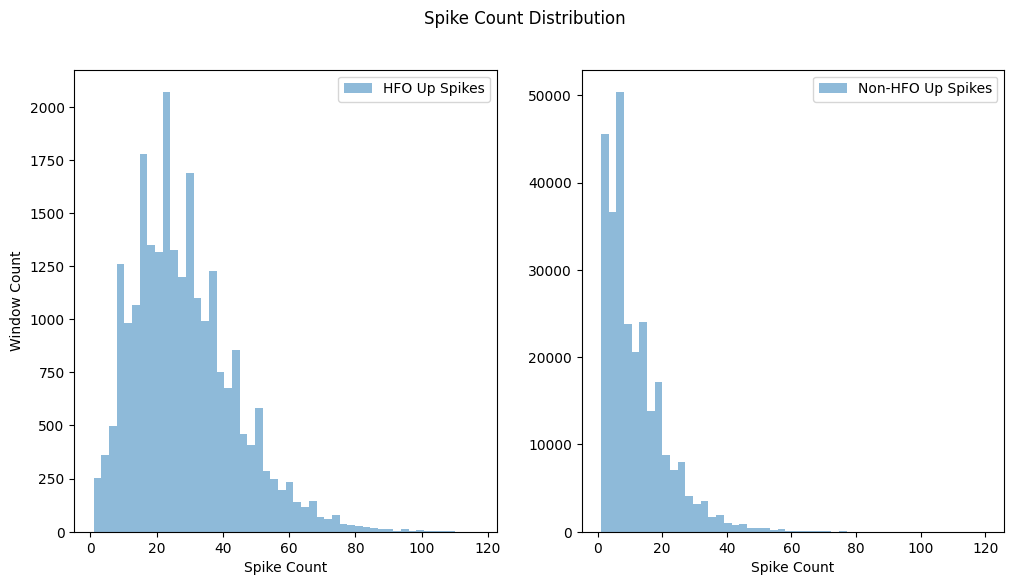

In [16]:
plt.subplots(1,2, figsize=(12, 6))
plt.suptitle('Spike Count Distribution')
plt.subplot(1, 2, 1)
plt.hist(og_total_hfo_counts,bins=50, alpha=0.5, label='HFO Up Spikes')
plt.xlabel('Spike Count')
plt.ylabel('Window Count')
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(og_total_nonhfo_counts, bins=50, alpha=0.5, label='Non-HFO Up Spikes')
plt.legend()
plt.xlabel('Spike Count')
plt.show()

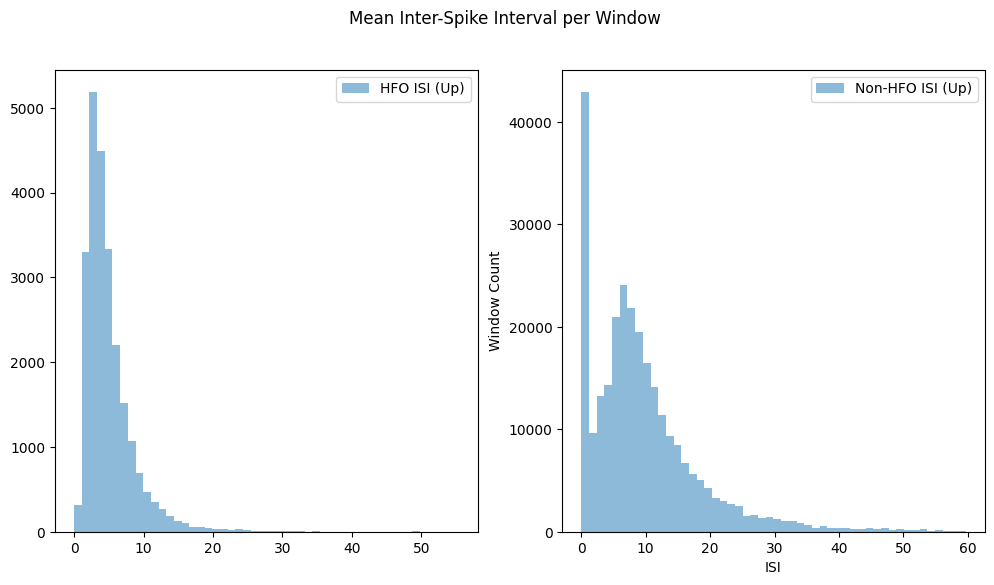

In [17]:
plt.subplots(1,2, figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(hfo_up_isi_mean, bins=50, alpha=0.5, label='HFO ISI (Up)')
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(nonhfo_up_isi_mean, bins=50, alpha=0.5, label='Non-HFO ISI (Up)')
plt.legend()
plt.suptitle('Mean Inter-Spike Interval per Window')
plt.xlabel('ISI')
plt.ylabel('Window Count')
plt.show()

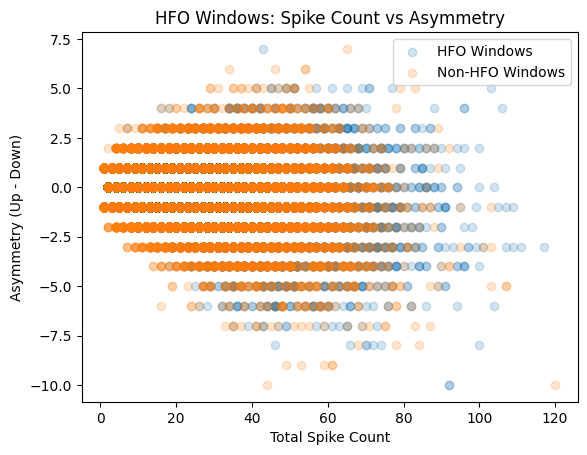

In [18]:
# Evaluate HFO windows
asymmetry_hfos = (hfo_up_counts - hfo_down_counts)
asymmetry_nonhfos = nonhfo_up_counts - nonhfo_down_counts

plt.scatter(og_total_hfo_counts,asymmetry_hfos , alpha=0.2, label='HFO Windows')
plt.scatter(og_total_nonhfo_counts,asymmetry_nonhfos, alpha=0.2, label='Non-HFO Windows')
plt.xlabel('Total Spike Count')
plt.ylabel('Asymmetry (Up - Down)')
plt.title('HFO Windows: Spike Count vs Asymmetry')
plt.legend()
plt.show()

c:\Users\NCN\Miniconda3\envs\lava_snn_ripples\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


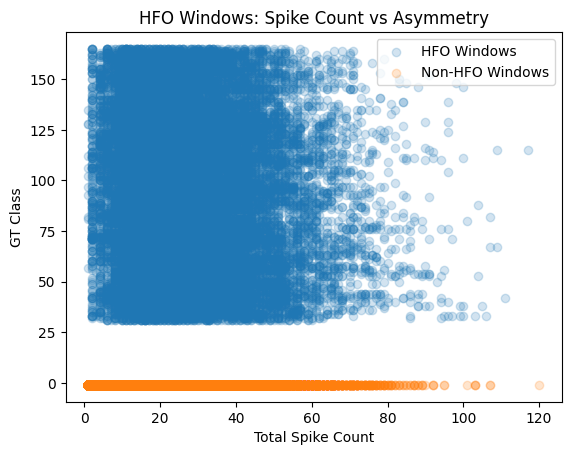

In [19]:
plt.scatter(og_total_hfo_counts,windowed_gt_hfo, alpha=0.2, label='HFO Windows')
plt.scatter(og_total_nonhfo_counts,windowed_gt_non_hfo, alpha=0.2, label='Non-HFO Windows')
plt.xlabel('Total Spike Count')
plt.ylabel('GT Class')
plt.title('HFO Windows: Spike Count vs Asymmetry')
plt.legend()
plt.show()

## Process Windows

In [20]:
p1_windowed_input_data,p1_windowed_gt,p1_ripple_ids=only_some_channels_per_ripple(windowed_input_data,windowed_gt,ripple_ids,1)


In [21]:
# See GT Class Distribution
# Set print options to see more elements
np.set_printoptions(linewidth=100, threshold=50, edgeitems=20)
print(f"Ground Truth Class Distribution: {np.unique(p1_windowed_gt, return_counts=True)}")



GT_HFO_MASK = p1_windowed_gt >= 0
# print(windowed_gt[0:1000])
# Define the number of windows with an HFO
num_hfo_windows = np.sum(GT_HFO_MASK)
print(f"Number of windows with an HFO: {num_hfo_windows}")
print(f"Percentage of windows with an HFO: {num_hfo_windows / p1_windowed_gt.shape[0] * 100:.2f}%")



Ground Truth Class Distribution: (array([ -1.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49., ..., 146., 147., 148., 149., 150., 151., 152., 153., 154.,
       155., 156., 157., 158., 159., 160., 161., 162., 163., 164., 165.], dtype=float32), array([275204,     12,     13,     11,     16,     17,     13,     17,     16,     19,     20,
           12,     23,     23,     14,     21,     31,     20,     25,     22, ...,     23,     14,
           20,     14,     20,      6,     10,      9,      7,     13,      8,      5,      8,
            8,      9,      8,      8,      6,      6,      9], dtype=int64))
Number of windows with an HFO: 2750
Percentage of windows with an HFO: 0.99%


In [22]:
# Find the indices to sort the input data by the nº of UP/DN spikes (descending order)
sorted_indices = np.argsort(
    -(np.sum(p1_windowed_input_data[:, :, 0], axis=1) + np.sum(p1_windowed_input_data[:, :, 1], axis=1)), 
)
sorted_spikes = p1_windowed_input_data[sorted_indices]
sorted_gt= p1_windowed_gt[sorted_indices]
sorted_ripples=p1_ripple_ids[sorted_indices]
sorted_up_spikes_per_window = np.sum(sorted_spikes[:, :, 0], axis=1)    # Sum along time axis
sorted_down_spikes_per_window = np.sum(sorted_spikes[:, :, 1], axis=1)  # Sum along time axis
print(f"sorted_indices: {sorted_indices}")
print(f"Sorted_data: {sorted_spikes.shape} | Sorted_gt: {sorted_gt.shape}")
print(f"Sorted_gt preview: {sorted_gt[:10]}")
print(f"GT first window: {sorted_gt[0]} | GT last window: {sorted_gt[-1]}")

sorted_indices: [  8984 276322 275664 275917  26110 276216  14962 276765 275420 276250 276115  31947  43018  24891
  15098 275490 276342 276000 276260 275775 ...  48193  89618  59814  89623  89632 125660 201816
 232236  89654  59817 125649 264117  89680 125627  89688  48152  48137  89692 273191 122306]
Sorted_data: (277954, 180, 2) | Sorted_gt: (277954,)
Sorted_gt preview: [ -1. 115.  42.  67.  -1.  82.  -1.  33.  38.  88.]
GT first window: -1.0 | GT last window: -1.0


In [23]:
sorted_gt_distribution=sorted_gt[:1000]
print(f"Sorted GT Distribution: {np.unique(sorted_gt_distribution, return_counts=True)}")

Sorted GT Distribution: (array([ -1.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49., ..., 141., 142., 143., 145., 146., 148., 149., 150., 151.,
       152., 153., 154., 155., 156., 157., 158., 159., 160., 162., 164.], dtype=float32), array([606,   2,   4,   2,   6,   2,   5,   1,   3,   3,   5,   3,   3,   5,   6,   2,   3,   3,
         5,   5, ...,   2,   1,   1,   2,   4,   3,   1,   3,   2,   3,   2,   1,   1,   1,   1,
         1,   1,   2,   2,   1], dtype=int64))


In [24]:
is_hfo = p1_windowed_gt >= 0
hfo_windows = p1_windowed_input_data[is_hfo]       # shape: (N_HFO, 180, 2)
non_hfo_windows = p1_windowed_input_data[~is_hfo]  # shape: (N_nonHFO, 180, 2)
windowed_gt_hfo = p1_windowed_gt[is_hfo]       # shape: (N_HFO, 180, 2)
windowed_gt_non_hfo = p1_windowed_gt[~is_hfo]  # shape: (N_nonHFO, 180, 2)

In [25]:
# Sum over time axis
hfo_up_counts = np.sum(hfo_windows[:, :, 0], axis=1)
hfo_down_counts = np.sum(hfo_windows[:, :, 1], axis=1)
total_hfo_counts= hfo_up_counts + hfo_down_counts
nonhfo_up_counts = np.sum(non_hfo_windows[:, :, 0], axis=1)
nonhfo_down_counts= np.sum(non_hfo_windows[:, :,1], axis=1)
total_nonhfo_counts = nonhfo_up_counts + nonhfo_down_counts

average_hfo_up_counts = np.mean(hfo_up_counts)
average_hfo_down_counts = np.mean(hfo_down_counts)
average_total_hfo_counts = np.mean(total_hfo_counts)
average_nonhfo_up_counts = np.mean(nonhfo_up_counts)
average_nonhfo_down_counts = np.mean(nonhfo_down_counts)
average_total_nonhfo_counts = np.mean(total_nonhfo_counts)
average_total_counts= (np.sum(total_hfo_counts)+np.sum(total_nonhfo_counts))/len(p1_windowed_input_data)

print(f"Average HFO Up Counts: {average_hfo_up_counts}")
print(f"Average HFO Down Counts: {average_hfo_down_counts}")
print(f"Average Total HFO Counts: {average_total_hfo_counts}")
print(f"Average Non-HFO Up Counts: {average_nonhfo_up_counts}")
print(f"Average Non-HFO Down Counts: {average_nonhfo_down_counts}")
print(f"Average Total Non-HFO Counts: {average_total_nonhfo_counts}")
print(f"Average Total Counts: {average_total_counts}")

Average HFO Up Counts: 19.825454545454544
Average HFO Down Counts: 20.39709090909091
Average Total HFO Counts: 40.222545454545454
Average Non-HFO Up Counts: 5.82976991613494
Average Non-HFO Down Counts: 5.870332553305912
Average Total Non-HFO Counts: 11.700102469440852
Average Total Counts: 11.982295631651281


In [26]:
# Example for all HFO windows (up channel):
hfo_up_isis = [get_isi(window[:, :]) for window in hfo_windows]
nonhfo_up_isis = [get_isi(window[:, :]) for window in non_hfo_windows]

hfo_up_isi_mean = np.array([np.mean(isi) if len(isi) > 0 else 0 for isi in hfo_up_isis])
nonhfo_up_isi_mean = np.array([np.mean(isi) if len(isi) > 0 else 0 for isi in nonhfo_up_isis])


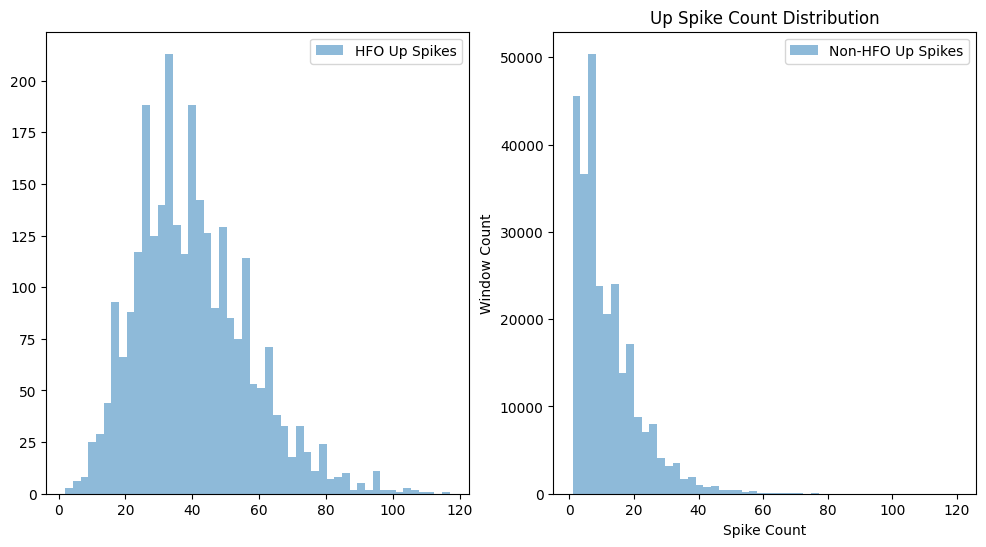

In [27]:
plt.subplots(1,2, figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(total_hfo_counts,bins=50, alpha=0.5, label='HFO Up Spikes')
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(total_nonhfo_counts, bins=50, alpha=0.5, label='Non-HFO Up Spikes')
plt.legend()
plt.title('Up Spike Count Distribution')
plt.xlabel('Spike Count')
plt.ylabel('Window Count')
plt.show()

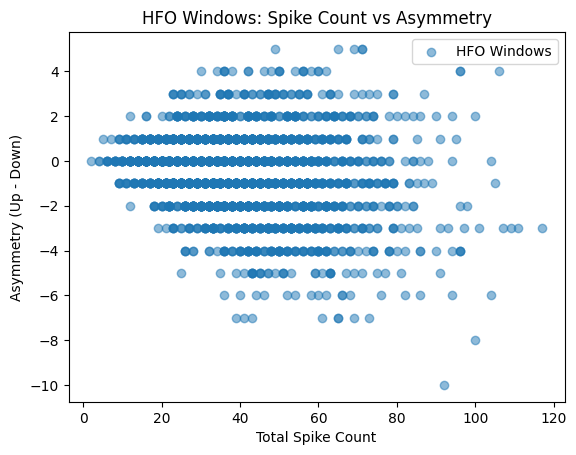

In [28]:
# Evaluate HFO windows
asymmetry_hfos = (hfo_up_counts - hfo_down_counts)
asymmetry_nonhfos = nonhfo_up_counts - nonhfo_down_counts

plt.scatter(total_hfo_counts,asymmetry_hfos , alpha=0.5, label='HFO Windows')
# plt.scatter(total_nonhfo_counts,asymmetry_nonhfos, alpha=0.5, label='Non-HFO Windows')
plt.xlabel('Total Spike Count')
plt.ylabel('Asymmetry (Up - Down)')
plt.title('HFO Windows: Spike Count vs Asymmetry')
plt.legend()
plt.show()

## Process - Remove Windows above thresholds

In [60]:
# print(average_total_hfo_counts)
# thresholds=[average_total_counts,average_total_hfo_counts*20]


nonhfo_threshold = np.percentile(og_total_nonhfo_counts, 90) 
hfo_activity_threshold = np.percentile(og_total_hfo_counts, 50) 
thresholds = [nonhfo_threshold, hfo_activity_threshold]

# thresholds=[100,50]
# p2_windowed_input_data,p2_windowed_gt,p2_ripple_ids=min_max_spike_threshold(p1_windowed_input_data,p1_windowed_gt,
#                                                                          p1_ripple_ids,MEAN_DETECTION_OFFSET,thresholds)

p2_windowed_input_data,p2_windowed_gt,p2_ripple_ids=min_max_spike_threshold_prob(windowed_input_data,windowed_gt,
                                                                         ripple_ids,MEAN_DETECTION_OFFSET,thresholds,max_prob=0.9,multiplier=2,decay=3,drop_fn=drop_exponential)

False Positive Removed (Prob 0.79) - Spikes: 8.0
False Negative Removed (Prob 0.20) - Spikes: 26.0
False Negative Removed (Prob 0.42) - Spikes: 29.0
False Negative Removed (Prob 0.84) - Spikes: 46.0
False Negative Removed (Prob 0.67) - Spikes: 35.0
False Negative Removed (Prob 0.78) - Spikes: 40.0
False Negative Removed (Prob 0.83) - Spikes: 45.0
False Negative Removed (Prob 0.78) - Spikes: 40.0
False Negative Removed (Prob 0.88) - Spikes: 56.0
False Negative Removed (Prob 0.61) - Spikes: 33.0
False Negative Removed (Prob 0.57) - Spikes: 32.0
False Negative Removed (Prob 0.42) - Spikes: 29.0
False Negative Removed (Prob 0.67) - Spikes: 35.0
False Negative Removed (Prob 0.82) - Spikes: 43.0
False Negative Removed (Prob 0.70) - Spikes: 36.0
False Negative Removed (Prob 0.90) - Spikes: 75.0
False Negative Removed (Prob 0.35) - Spikes: 28.0
False Negative Removed (Prob 0.89) - Spikes: 63.0
False Negative Removed (Prob 0.89) - Spikes: 64.0
False Negative Removed (Prob 0.70) - Spikes: 36.0
F

In [61]:
# See GT Class Distribution
# Set print options to see more elements
np.set_printoptions(linewidth=100, threshold=50, edgeitems=20)
print(f"Ground Truth Class Distribution: {np.unique(p2_windowed_gt, return_counts=True)}")



GT_HFO_MASK = p2_windowed_gt >= 0
# print(windowed_gt[0:1000])
# Define the number of windows with an HFO
num_hfo_windows = np.sum(GT_HFO_MASK)
print(f"Number of windows with an HFO: {num_hfo_windows}")
print(f"Percentage of windows with an HFO: {num_hfo_windows / p2_windowed_gt.shape[0] * 100:.2f}%")

Ground Truth Class Distribution: (array([ -1.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49., ..., 146., 147., 148., 149., 150., 151., 152., 153., 154.,
       155., 156., 157., 158., 159., 160., 161., 162., 163., 164., 165.], dtype=float32), array([261650,    100,    138,    110,    149,    174,    125,    147,    159,    162,    170,
          100,    190,    176,    121,    166,    194,    110,    147,    139, ...,    119,     81,
          120,     83,     98,     70,    102,     93,     91,    118,    103,     84,    106,
          112,    110,     66,    124,    106,     90,    103], dtype=int64))
Number of windows with an HFO: 17654
Percentage of windows with an HFO: 6.32%


In [62]:
# Find the indices to sort the input data by the nº of UP/DN spikes (descending order)
sorted_indices = np.argsort(
    -(np.sum(p2_windowed_input_data[:, :, 0], axis=1) + np.sum(p2_windowed_input_data[:, :, 1], axis=1)), 
)
sorted_spikes = p2_windowed_input_data[sorted_indices]
sorted_gt= p2_windowed_gt[sorted_indices]
sorted_ripples=p2_ripple_ids[sorted_indices]
sorted_up_spikes_per_window = np.sum(sorted_spikes[:, :, 0], axis=1)    # Sum along time axis
sorted_down_spikes_per_window = np.sum(sorted_spikes[:, :, 1], axis=1)  # Sum along time axis
print(f"sorted_indices: {sorted_indices}")
print(f"Sorted_data: {sorted_spikes.shape} | Sorted_gt: {sorted_gt.shape}")
print(f"Sorted_gt preview: {sorted_gt[:10]}")
print(f"GT first window: {sorted_gt[0]} | GT last window: {sorted_gt[-1]}")

sorted_indices: [ 13706   6642  29644  23998  12397   8273 207621  34246  12731  10548 214742   3594   8911 200693
   2530  13822  18154 193376  12823 186197 ... 113856 159319 159324 262876 247239 138108 183132
 258365 138100 183092 138055  77759 113899 258377 239643 113906 113907  49256  62653 248183]
Sorted_data: (279304, 180, 2) | Sorted_gt: (279304,)
Sorted_gt preview: [115.  42. 115.  67.  82.  67.  33.  38.  88.  53.]
GT first window: 115.0 | GT last window: -1.0


In [63]:
sorted_gt_distribution=sorted_gt[:1000]
sorted_ripple_distribution=sorted_ripples[:1000]

print(f"Sorted GT Distribution: {np.unique(sorted_gt_distribution, return_counts=True)}")
print(f"Sorted Ripple Distribution: {np.unique(sorted_ripple_distribution, return_counts=True)}")


Sorted GT Distribution: (array([ -1.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,
        46.,  47.,  48.,  49.,  50., ..., 142., 143., 145., 146., 148., 149., 150., 151., 152.,
       153., 154., 155., 156., 157., 158., 159., 160., 162., 163., 164.], dtype=float32), array([53,  6, 11,  7,  2, 14,  4, 11,  4, 15,  8, 18, 13, 23,  3,  8,  8,  5,  9,  9, ...,  1,  1,
       11,  9,  7,  1,  6,  1,  8,  3,  6,  1,  2,  1,  6,  4,  6,  3,  1,  3], dtype=int64))
Sorted Ripple Distribution: (array([  -1,   21,   25,   36,   38,   53,   55,   68,   69,   80,   86,   91,  103,  110,  112,
        116,  118,  122,  138,  144, ..., 2113, 2256, 2316, 2330, 2595, 2685, 2738, 2739, 2790,
       2802, 2820, 2822, 2838, 2855, 2877, 2885, 2916, 2945, 2993, 3009]), array([53,  1,  2,  2,  4,  3,  2,  3,  7,  5,  5,  1,  6,  7,  4,  7,  1,  6,  6,  3, ...,  1,  3,
        4,  1,  2,  3,  4,  1,  1,  2,  1,  4,  1,  2,  1,  6,  3,  2,  3,  1], dtype=int64))


In [64]:
is_hfo = p2_windowed_gt >= 0
hfo_windows = p2_windowed_input_data[is_hfo]       # shape: (N_HFO, 180, 2)
non_hfo_windows = p2_windowed_input_data[~is_hfo]  # shape: (N_nonHFO, 180, 2)
windowed_gt_hfo = p2_windowed_gt[is_hfo]       # shape: (N_HFO, 180, 2)
windowed_gt_non_hfo = p2_windowed_gt[~is_hfo]  # shape: (N_nonHFO, 180, 2)

In [65]:
# Sum over time axis
hfo_up_counts = np.sum(hfo_windows[:, :, 0], axis=1)
hfo_down_counts = np.sum(hfo_windows[:, :, 1], axis=1)
total_hfo_counts= hfo_up_counts + hfo_down_counts
nonhfo_up_counts = np.sum(non_hfo_windows[:, :, 0], axis=1)
nonhfo_down_counts= np.sum(non_hfo_windows[:, :,1], axis=1)
total_nonhfo_counts = nonhfo_up_counts + nonhfo_down_counts

average_hfo_up_counts = np.mean(hfo_up_counts)
average_hfo_down_counts = np.mean(hfo_down_counts)
average_total_hfo_counts = np.mean(total_hfo_counts)
average_nonhfo_up_counts = np.mean(nonhfo_up_counts)
average_nonhfo_down_counts = np.mean(nonhfo_down_counts)
average_total_nonhfo_counts = np.mean(total_nonhfo_counts)
average_total_counts= (np.sum(total_hfo_counts)+np.sum(total_nonhfo_counts))/len(p2_windowed_input_data)
print(f"Average HFO Up Counts: {average_hfo_up_counts}")
print(f"Average HFO Down Counts: {average_hfo_down_counts}")
print(f"Average Total HFO Counts: {average_total_hfo_counts}")
print(f"Average Non-HFO Up Counts: {average_nonhfo_up_counts}")
print(f"Average Non-HFO Down Counts: {average_nonhfo_down_counts}")
print(f"Average Total Non-HFO Counts: {average_total_nonhfo_counts}")
print(f"Average Total Counts: {average_total_counts}")
print(f"Number of windows with an HFO: {num_hfo_windows}")
print(f"Number of windows without an HFO:", len(p2_windowed_input_data)-num_hfo_windows)

Average HFO Up Counts: 16.62790302481024
Average HFO Down Counts: 17.03761187266342
Average Total HFO Counts: 33.66551489747366
Average Non-HFO Up Counts: 5.1803286833556275
Average Non-HFO Down Counts: 5.206218230460539
Average Total Non-HFO Counts: 10.386546913816167
Average Total Counts: 11.857943316243233
Number of windows with an HFO: 17654
Number of windows without an HFO: 261650


In [66]:
# Example for all HFO windows (up channel):
hfo_up_isis = [get_isi(window[:, :]) for window in hfo_windows]
nonhfo_up_isis = [get_isi(window[:, :]) for window in non_hfo_windows]

hfo_up_isi_mean = np.array([np.mean(isi) if len(isi) > 0 else 0 for isi in hfo_up_isis])
nonhfo_up_isi_mean = np.array([np.mean(isi) if len(isi) > 0 else 0 for isi in nonhfo_up_isis])

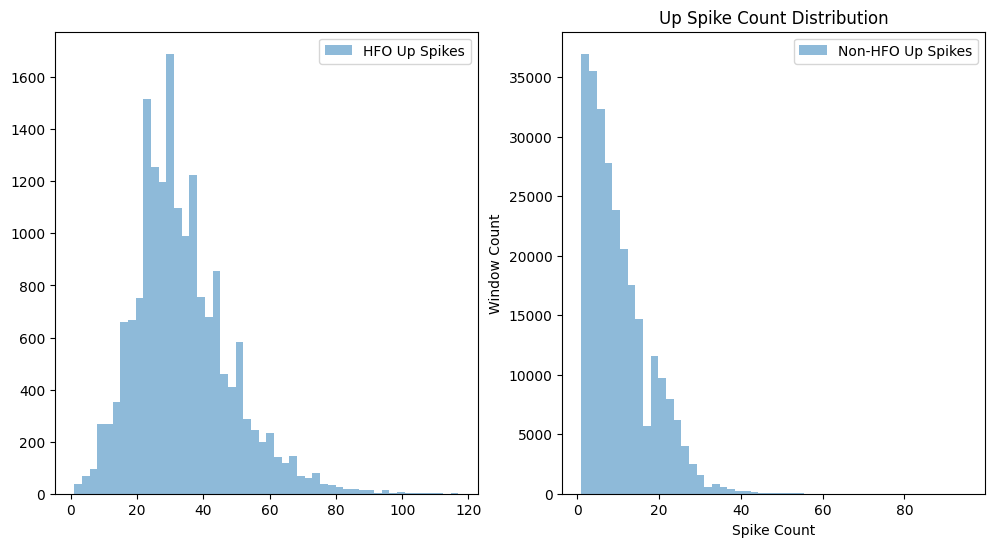

In [67]:
plt.subplots(1,2, figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(total_hfo_counts,bins=50, alpha=0.5, label='HFO Up Spikes')
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(total_nonhfo_counts, bins=50, alpha=0.5, label='Non-HFO Up Spikes')
plt.legend()
plt.title('Up Spike Count Distribution')
plt.xlabel('Spike Count')
plt.ylabel('Window Count')
plt.show()

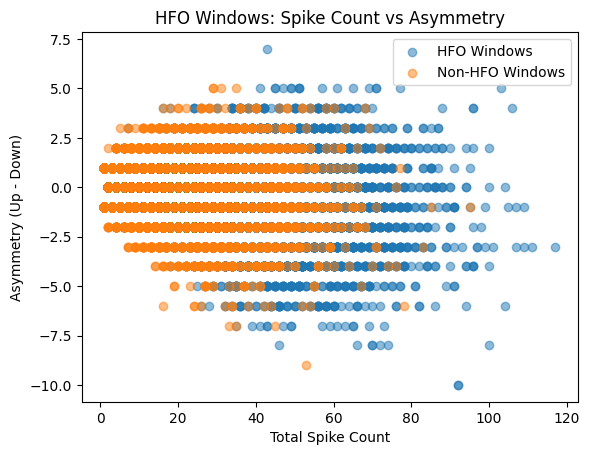

In [68]:
# Evaluate HFO windows
asymmetry_hfos = (hfo_up_counts - hfo_down_counts)
asymmetry_nonhfos = nonhfo_up_counts - nonhfo_down_counts

plt.scatter(total_hfo_counts,asymmetry_hfos , alpha=0.5, label='HFO Windows')
plt.scatter(total_nonhfo_counts,asymmetry_nonhfos, alpha=0.5, label='Non-HFO Windows')
plt.xlabel('Total Spike Count')
plt.ylabel('Asymmetry (Up - Down)')
plt.title('HFO Windows: Spike Count vs Asymmetry')
plt.legend()
plt.show()

Text(0.5, 1.0, 'HFO Windows: Spike Count vs Asymmetry')

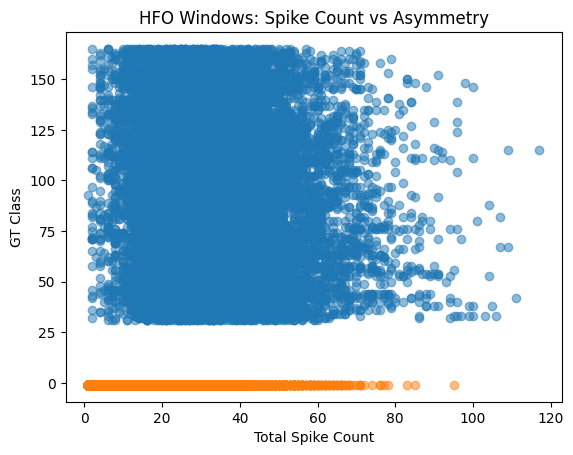

In [69]:
plt.scatter(total_hfo_counts,windowed_gt_hfo, alpha=0.5, label='HFO Windows')
plt.scatter(total_nonhfo_counts,windowed_gt_non_hfo, alpha=0.5, label='Non-HFO Windows')
plt.xlabel('Total Spike Count')
plt.ylabel('GT Class')
plt.title('HFO Windows: Spike Count vs Asymmetry')

## After Undersampling Non-Ripples

In [70]:
from snnTorch.utils.training import undersample_majority, oversample_minority
intermediate_input, intermediate_gt = windowed_input_data, windowed_gt  # Default: No Balancing
balance=True
if balance:
    # intermediate_input, intermediate_gt = undersample_majority(windowed_input_data, windowed_gt)
    intermediate_input, intermediate_gt = undersample_majority(p2_windowed_input_data, p2_windowed_gt)  

# Print the number of samples in each class
print(f"Intermediate GT Class Distribution: {np.unique(intermediate_gt, return_counts=True)}")
print(f"Intermediate Window Input Data Shape: {intermediate_input.shape}")


Intermediate GT Class Distribution: (array([ -1.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49., ..., 146., 147., 148., 149., 150., 151., 152., 153., 154.,
       155., 156., 157., 158., 159., 160., 161., 162., 163., 164., 165.], dtype=float32), array([17654,   100,   138,   110,   149,   174,   125,   147,   159,   162,   170,   100,   190,
         176,   121,   166,   194,   110,   147,   139, ...,   119,    81,   120,    83,    98,
          70,   102,    93,    91,   118,   103,    84,   106,   112,   110,    66,   124,   106,
          90,   103], dtype=int64))
Intermediate Window Input Data Shape: (35308, 180, 2)


In [71]:
is_hfo= intermediate_gt >= 0
hfo_windows = intermediate_input[is_hfo]       # shape: (N_HFO, 180, 2)
non_hfo_windows = intermediate_input[~is_hfo]  # shape: (N_nonHFO, 180, 2)
windowed_gt_hfo = intermediate_gt[is_hfo]       # shape: (N_HFO, 180, 2)
windowed_gt_non_hfo = intermediate_gt[~is_hfo]  # shape: (N_nonHFO, 180, 2)
print(f"Number of HFO windows: {hfo_windows.shape[0]}")
print(f"Number of Non-HFO windows: {non_hfo_windows.shape[0]}")

Number of HFO windows: 17654
Number of Non-HFO windows: 17654


In [72]:
# Sum over time axis
hfo_up_counts = np.sum(hfo_windows[:, :, 0], axis=1)
hfo_down_counts = np.sum(hfo_windows[:, :, 1], axis=1)
total_hfo_counts= hfo_up_counts + hfo_down_counts
nonhfo_up_counts = np.sum(non_hfo_windows[:, :, 0], axis=1)
nonhfo_down_counts= np.sum(non_hfo_windows[:, :,1], axis=1)
total_nonhfo_counts = nonhfo_up_counts + nonhfo_down_counts

average_hfo_up_counts = np.mean(hfo_up_counts)
average_hfo_down_counts = np.mean(hfo_down_counts)
average_total_hfo_counts = np.mean(total_hfo_counts)
average_nonhfo_up_counts = np.mean(nonhfo_up_counts)
average_nonhfo_down_counts = np.mean(nonhfo_down_counts)
average_total_nonhfo_counts = np.mean(total_nonhfo_counts)
average_total_counts= (np.sum(total_hfo_counts)+np.sum(total_nonhfo_counts))/len(intermediate_input)

print(f"Average HFO Up Counts: {average_hfo_up_counts}")
print(f"Average HFO Down Counts: {average_hfo_down_counts}")
print(f"Average Total HFO Counts: {average_total_hfo_counts}")
print(f"Average Non-HFO Up Counts: {average_nonhfo_up_counts}")
print(f"Average Non-HFO Down Counts: {average_nonhfo_down_counts}")
print(f"Average Total Non-HFO Counts: {average_total_nonhfo_counts}")
print(f"Average Total Counts: {average_total_counts}")

# Example for all HFO windows (up channel):
hfo_up_isis = [get_isi(window[:, :]) for window in hfo_windows]
nonhfo_up_isis = [get_isi(window[:, :]) for window in non_hfo_windows]

hfo_up_isi_mean = np.array([np.mean(isi) if len(isi) > 0 else 0 for isi in hfo_up_isis])
nonhfo_up_isi_mean = np.array([np.mean(isi) if len(isi) > 0 else 0 for isi in nonhfo_up_isis])


Average HFO Up Counts: 16.62790302481024
Average HFO Down Counts: 17.03761187266342
Average Total HFO Counts: 33.66551489747366
Average Non-HFO Up Counts: 5.18958876175371
Average Non-HFO Down Counts: 5.224028548770817
Average Total Non-HFO Counts: 10.413617310524527
Average Total Counts: 22.039566103999093


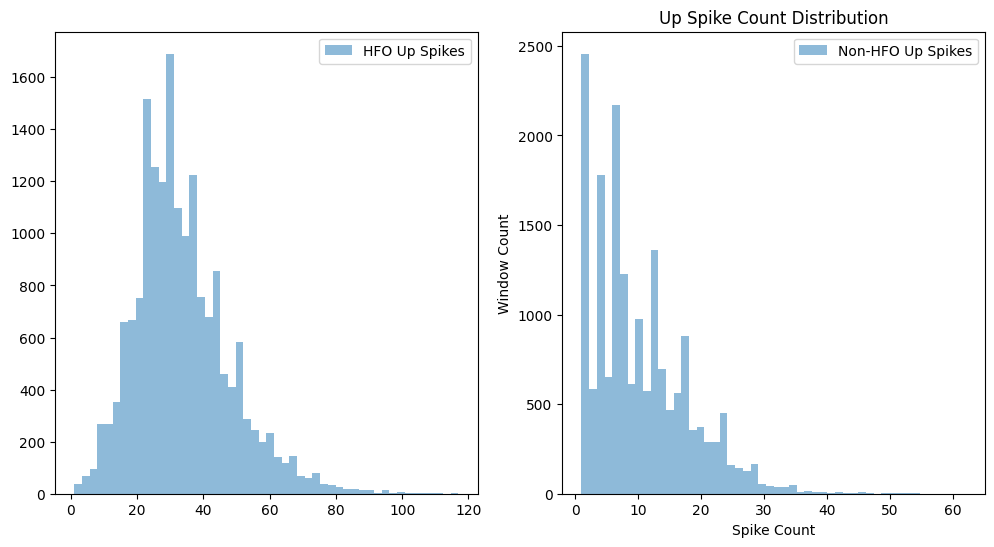

In [73]:
plt.subplots(1,2, figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(total_hfo_counts,bins=50, alpha=0.5, label='HFO Up Spikes')
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(total_nonhfo_counts, bins=50, alpha=0.5, label='Non-HFO Up Spikes')
plt.legend()
plt.title('Up Spike Count Distribution')
plt.xlabel('Spike Count')
plt.ylabel('Window Count')
plt.show()

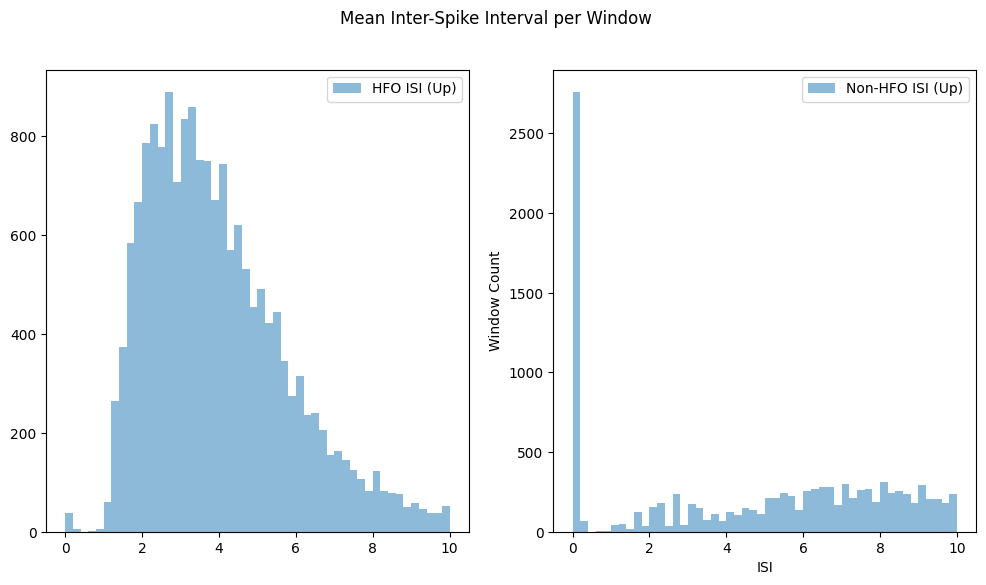

In [74]:
plt.subplots(1,2, figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(hfo_up_isi_mean,range=(0,10), bins=50, alpha=0.5, label='HFO ISI (Up)')
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(nonhfo_up_isi_mean,range=(0,10), bins=50, alpha=0.5, label='Non-HFO ISI (Up)')
plt.legend()
plt.suptitle('Mean Inter-Spike Interval per Window')
plt.xlabel('ISI')
plt.ylabel('Window Count')
plt.show()

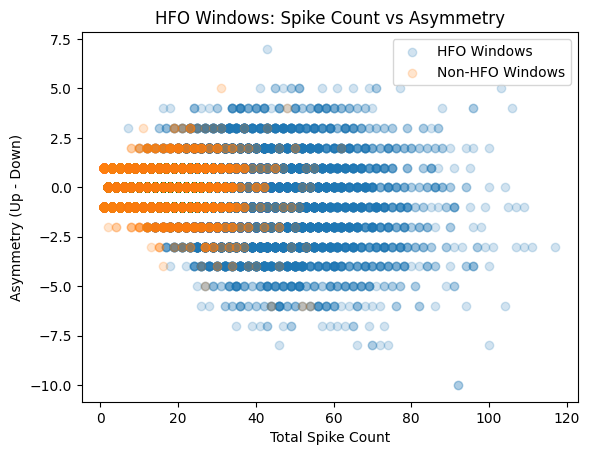

In [75]:
# Evaluate HFO windows
asymmetry_hfos = (hfo_up_counts - hfo_down_counts)
asymmetry_nonhfos = nonhfo_up_counts - nonhfo_down_counts

plt.scatter(total_hfo_counts,asymmetry_hfos , alpha=0.2, label='HFO Windows')
plt.scatter(total_nonhfo_counts,asymmetry_nonhfos, alpha=0.2, label='Non-HFO Windows')
plt.xlabel('Total Spike Count')
plt.ylabel('Asymmetry (Up - Down)')
plt.title('HFO Windows: Spike Count vs Asymmetry')
plt.legend()
plt.show()

Text(0.5, 1.0, 'HFO Windows: Spike Count vs Asymmetry')

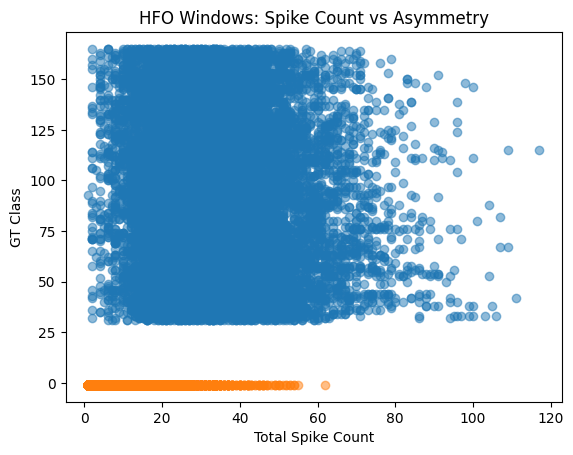

In [76]:
plt.scatter(total_hfo_counts,windowed_gt_hfo, alpha=0.5, label='HFO Windows')
plt.scatter(total_nonhfo_counts,windowed_gt_non_hfo, alpha=0.5, label='Non-HFO Windows')
plt.xlabel('Total Spike Count')
plt.ylabel('GT Class')
plt.title('HFO Windows: Spike Count vs Asymmetry')

In [43]:
# Save the windowed 
# input data and ground truth to a file
save=False
if save:
    windowed_save=os.path.join(curr_dir,"windowed_data")
    os.makedirs(windowed_save, exist_ok=True)
    np.save(os.path.join(windowed_save, "filtered_windows.npy"), filtered_windows, allow_pickle=True)
    np.save(os.path.join(windowed_save, "windowed_input_data.npy"), windowed_input_data, allow_pickle=True)
    np.save(os.path.join(windowed_save,"windowed_gt.npy"), windowed_gt, allow_pickle=True)
    # Save the configuration to a JSON file
    with open(os.path.join(windowed_save, "config.json"), 'w') as f:
        json.dump(config, f, indent=4)